# Анализ данных и прогнозирование стоимости автомобиля на вторичном рынке

## Решение задачи регрессии

Этот набор данных содержит автомобили с автомобильного рынка Индии. Каждая запись в наборе данных — это автомобиль с набором характеристик. Я должен проанализировать эти данные, а затем создать модель, которая может предсказать цену для любого автомобиля. Это задача регрессии машинного обучения. Каждый автомобиль имеет следующие признаки:<br>
1) Unnamed: 0 - индекс записи в наборе данных<br>
2) Name: наименование автомобиля<br>
3) Location: место продажи автомобиля<br>
4) Year: год выпуска автомобиля<br>
5) Kilometers_Driven: пробег автомобиля в км<br>
6) Fuel_Type: тип топлива автомобиля<br>
7) Transmission: трансмиссия автомобиля<br>
8) Owner_Type: тип владельца автомобиля (первый, второй и т.д.)<br>
9) Mileage: расход топлива автомобиля в км/л или км/кг<br>
10) Engine: рабочий объем двигателя в куб.см.<br>
11) Power: максимальная мощность двигателя в л.с.<br>
12) Seats: число сидений в автомобиле<br>
13) New_Price: цена такого же нового автомобиля<br>
14) Price: цена подержанного автомобиля в лакхах индийских рупий (таргет)



В первую очередь загрузим в проект модули, функционал которых нам понадобится в дальнейшем.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, HuberRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, max_error, r2_score, explained_variance_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

Модуль numpy нам предоставляет качественные многомерные массивы, модуль pandas предоставляет серии и датафреймы, в которых удобно хранить данные. Модуль sklearn (scikit-learn) предоставляет нам объёмный функционал для анализа и обработки данных, а также множество моделей для решения задачи регрессии. Модуль optuna позволяет удобно подбирать оптимальные гиперпараметры в модели. Модули matplotlib и seaborn - популярные фреймворки для визуализации данных. Модуль warnings позволяет отключить всплывающие уведомления.

# Предварительная обработка данных

Выгрузим имеющиеся данные и взглянём на них.

In [2]:
train_data = pd.read_csv("C://used_cars/train-data.csv")
test_data = pd.read_csv("C://used_cars/test-data.csv")

print('Train data head\n ', train_data.head())
print('\nTrain data tail\n ', train_data.tail())
print('\nData description\n ', train_data.describe())
print('\nData technical information\n')
train_data.info()

print('Test data head\n ', test_data.head())
print('\nTest data tail\n ', test_data.tail())
print('\nData description\n ', test_data.describe())
print('\nData technical information\n')
test_data.info()

Train data head
     Unnamed: 0                              Name    Location  Year   
0           0            Maruti Wagon R LXI CNG      Mumbai  2010  \
1           1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015   
2           2                      Honda Jazz V     Chennai  2011   
3           3                 Maruti Ertiga VDI     Chennai  2012   
4           4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013   

   Kilometers_Driven Fuel_Type Transmission Owner_Type     Mileage   Engine   
0              72000       CNG       Manual      First  26.6 km/kg   998 CC  \
1              41000    Diesel       Manual      First  19.67 kmpl  1582 CC   
2              46000    Petrol       Manual      First   18.2 kmpl  1199 CC   
3              87000    Diesel       Manual      First  20.77 kmpl  1248 CC   
4              40670    Diesel    Automatic     Second   15.2 kmpl  1968 CC   

       Power  Seats  New_Price  Price  
0  58.16 bhp    5.0        NaN   1.75  
1  126.2 bhp

Удалим столбец, содержащий идентификатор, и столбец, содержащий цену на такой же автомобиль, будь он новым, поскольку данный столбец содержит 86% пропущенных значений, что слишком много для одного признака.

In [3]:
train_data = train_data.drop(['Unnamed: 0', 'New_Price'], axis=1)
test_data = test_data.drop(['Unnamed: 0', 'New_Price'], axis=1)

Проверим наши данные на пропущенные значения.

In [4]:
print('Missing values in train\n ', train_data.isna().sum())
print('\nMissing values in test\n ', test_data.isna().sum())

Missing values in train
  Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

Missing values in test
  Name                  0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               10
Power                10
Seats                11
dtype: int64


Пропущенные значения содержатся как в обучающей выборке, так и в тестовой. Строки с пропущенными значениями из теста мы просто удалим, а пропущенные значения из трейна мы заполним позже.

In [5]:
test_data.dropna(how='any', inplace=True)
test_data.reset_index(drop=True, inplace=True)

Проверим данные на дубликаты.

In [6]:
print('Duplicates in train\n ', train_data.duplicated().sum())
print('\nDuplicates in test\n ', test_data.duplicated().sum())

Duplicates in train
  0

Duplicates in test
  1


В трейне нет дубликатов, в тесте имеется один дубликат: удалим его.

In [7]:
test_data.drop_duplicates(inplace=True)
test_data.reset_index(drop=True, inplace=True)

## Предобработка признаков

Из столбца, содержащего наименование автомобиля, выделим столбец, содержащий марку автомобиля (выделить столбец из имеющихся данных, содержащий модель автомобиля, проблематично).

In [8]:
train_data['Name'] = train_data['Name'].str.split().str[0]
test_data['Name'] = test_data['Name'].str.split().str[0]
train_data['Name'].replace(to_replace='Land', value='Land Rover', inplace=True)
train_data['Name'].replace(to_replace='Ambassador', value='Hindustan', inplace=True)
train_data['Name'].replace(to_replace='ISUZU', value='Isuzu', inplace=True)
test_data['Name'].replace(to_replace='Land', value='Land Rover', inplace=True)
test_data['Name'].replace(to_replace='ISUZU', value='Isuzu', inplace=True)

Проверим: все ли модели из теста содержатся в трейне?

In [9]:
print(set(test_data['Name']).issubset(set(train_data['Name'])))

False


Имеются модели в тесте, которых нет в трейне. Удалим их.

In [10]:
diff = set(test_data['Name']).difference(set(train_data['Name']))
test_data = test_data.drop(test_data[test_data['Name'].isin(diff)].index, axis=0).reset_index(drop=True)

Преобразуем остальные признаки к численному виду (удалим единицы измерения). Стоит заметить, что в столбце "мощность" имеется значение "null", строки с которым мы удалим.

In [11]:
train_data['Mileage'] = train_data['Mileage'].str.split().str[0].astype('float')
train_data['Engine'] = train_data['Engine'].str.split().str[0].astype('float')
train_data['Power'] = train_data['Power'].str.split().str[0]
train_data.drop(train_data[train_data['Power'] == 'null'].index, axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data['Power'] = train_data['Power'].astype('float')
train_data['Kilometers_Driven'] = train_data['Kilometers_Driven'].astype('float')

In [12]:
test_data['Mileage'] = test_data['Mileage'].str.split().str[0].astype('float')
test_data['Engine'] = test_data['Engine'].str.split().str[0].astype('float')
test_data['Power'] = test_data['Power'].str.split().str[0]
test_data.drop(test_data[test_data['Power'] == 'null'].index, axis=0, inplace=True)
test_data.reset_index(drop=True, inplace=True)
test_data['Power'] = test_data['Power'].astype('float')
test_data['Kilometers_Driven'] = test_data['Kilometers_Driven'].astype('float')

Посмотрим на кардинальность категориальных признаков и на сами категории.

In [13]:
print("Cardinality of 'Name' feature: ", train_data['Name'].nunique())
print("Cardinality of 'Location' feature: ", train_data['Location'].nunique())
print("Cardinality of 'Fuel_Type' feature: ", train_data['Fuel_Type'].nunique())
print("Cardinality of 'Transmission' feature: ", train_data['Transmission'].nunique())
print("Cardinality of 'Owner_Type' feature: ", train_data['Owner_Type'].nunique())
print("Categories of 'Name' feature: ", train_data['Name'].unique())
print("Categories of 'Location' feature: ", train_data['Location'].unique())
print("Categories of 'Fuel_Type' feature: ", train_data['Fuel_Type'].unique())
print("Categories of 'Transmission' feature: ", train_data['Transmission'].unique())
print("Categories of 'Owner_Type' feature: ", train_data['Owner_Type'].unique())

Cardinality of 'Name' feature:  29
Cardinality of 'Location' feature:  11
Cardinality of 'Fuel_Type' feature:  5
Cardinality of 'Transmission' feature:  2
Cardinality of 'Owner_Type' feature:  4
Categories of 'Name' feature:  ['Maruti' 'Hyundai' 'Honda' 'Audi' 'Nissan' 'Toyota' 'Volkswagen' 'Tata'
 'Land Rover' 'Mitsubishi' 'Renault' 'Mercedes-Benz' 'BMW' 'Mahindra'
 'Ford' 'Porsche' 'Datsun' 'Jaguar' 'Volvo' 'Chevrolet' 'Skoda' 'Mini'
 'Fiat' 'Jeep' 'Hindustan' 'Isuzu' 'Force' 'Bentley' 'Lamborghini']
Categories of 'Location' feature:  ['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']
Categories of 'Fuel_Type' feature:  ['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']
Categories of 'Transmission' feature:  ['Manual' 'Automatic']
Categories of 'Owner_Type' feature:  ['First' 'Second' 'Fourth & Above' 'Third']


Закодируем категориальные признаки: тип владельца закодируем через OrdinalEncoder, поскольку имеется отношение порядка, остальные признаки закодируем через OneHotEncoder.

In [14]:
ord_enc = OrdinalEncoder(categories=[np.array(['First', 'Second', 'Third', 'Fourth & Above'])]).fit(train_data['Owner_Type'].unique()[:, None])
train_data['Owner_Type'] = ord_enc.transform(train_data['Owner_Type'].to_numpy()[:, None])
test_data['Owner_Type'] = ord_enc.transform(test_data['Owner_Type'].to_numpy()[:, None])

onehot_enc_maker = OneHotEncoder(sparse_output=False)

onehot_enc_maker.fit(train_data['Name'].to_numpy()[:, None])
onehot_res = pd.DataFrame(onehot_enc_maker.transform(train_data['Name'].to_numpy()[:, None]), columns=['Audi', 'BMW', 'Bentley', 'Chevrolet', 'Datsun', 'Fiat', 'Force', 'Ford', 'Hindustan', 'Honda', 'Hyundai', 'Isuzu', 'Jaguar', 'Jeep', 'Lamborghini', 'Land Rover', 'Mahindra', 'Maruti', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'])
train_data = pd.concat([onehot_res, train_data.drop('Name', axis=1)], axis=1)
onehot_res = pd.DataFrame(onehot_enc_maker.transform(test_data['Name'].to_numpy()[:, None]), columns=['Audi', 'BMW', 'Bentley', 'Chevrolet', 'Datsun', 'Fiat', 'Force', 'Ford', 'Hindustan', 'Honda', 'Hyundai', 'Isuzu', 'Jaguar', 'Jeep', 'Lamborghini', 'Land Rover', 'Mahindra', 'Maruti', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo'])
test_data = pd.concat([onehot_res, test_data.drop('Name', axis=1)], axis=1)

onehot_enc_location = OneHotEncoder(sparse_output=False)

onehot_enc_location.fit(train_data['Location'].to_numpy()[:, None])
onehot_res = pd.DataFrame(onehot_enc_location.transform(train_data['Location'].to_numpy()[:, None]), columns=['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi', 'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune'])
train_data = pd.concat([onehot_res, train_data.drop('Location', axis=1)], axis=1)
onehot_res = pd.DataFrame(onehot_enc_location.transform(test_data['Location'].to_numpy()[:, None]), columns=['Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi', 'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune'])
test_data = pd.concat([onehot_res, test_data.drop('Location', axis=1)], axis=1)

onehot_enc_fuel = OneHotEncoder(sparse_output=False)

onehot_enc_fuel.fit(train_data['Fuel_Type'].to_numpy()[:, None])
onehot_res = pd.DataFrame(onehot_enc_fuel.transform(train_data['Fuel_Type'].to_numpy()[:, None]), columns=['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'])
train_data = pd.concat([onehot_res, train_data.drop('Fuel_Type', axis=1)], axis=1)
onehot_res = pd.DataFrame(onehot_enc_fuel.transform(test_data['Fuel_Type'].to_numpy()[:, None]), columns=['CNG', 'Diesel', 'Electric', 'LPG', 'Petrol'])
test_data = pd.concat([onehot_res, test_data.drop('Fuel_Type', axis=1)], axis=1)

onehot_enc_transmission = OneHotEncoder(sparse_output=False)

onehot_enc_transmission.fit(train_data['Transmission'].to_numpy()[:, None])
onehot_res = pd.DataFrame(onehot_enc_transmission.transform(train_data['Transmission'].to_numpy()[:, None]), columns=['Automatic', 'Manual'])
train_data = pd.concat([onehot_res, train_data.drop('Transmission', axis=1)], axis=1)
onehot_res = pd.DataFrame(onehot_enc_transmission.transform(test_data['Transmission'].to_numpy()[:, None]), columns=['Automatic', 'Manual'])
test_data = pd.concat([onehot_res, test_data.drop('Transmission', axis=1)], axis=1)

Заполним пропущенные значения в трейне через KNNImputer, который аппроксимирует пропущенное значения на основе k ближайших соседей.

In [15]:
imputer = KNNImputer()
cols = train_data.columns
train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=cols)
print('Train data technical information after filling missing values')
train_data.info()

Train data technical information after filling missing values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5912 entries, 0 to 5911
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Automatic          5912 non-null   float64
 1   Manual             5912 non-null   float64
 2   CNG                5912 non-null   float64
 3   Diesel             5912 non-null   float64
 4   Electric           5912 non-null   float64
 5   LPG                5912 non-null   float64
 6   Petrol             5912 non-null   float64
 7   Ahmedabad          5912 non-null   float64
 8   Bangalore          5912 non-null   float64
 9   Chennai            5912 non-null   float64
 10  Coimbatore         5912 non-null   float64
 11  Delhi              5912 non-null   float64
 12  Hyderabad          5912 non-null   float64
 13  Jaipur             5912 non-null   float64
 14  Kochi              5912 non-null   float64
 15  Kolkata   

Пропущенных значений больше не имеется.

Выполним проверку на выбросы.

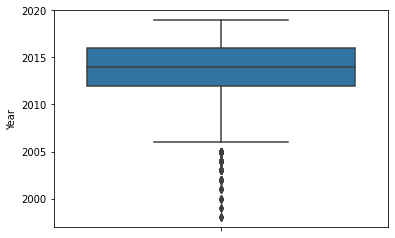

In [16]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Year')
plt.xticks(fontsize=5)
plt.show()

В годе выпуска нет выбросов.

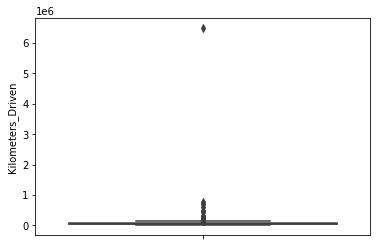

In [17]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Kilometers_Driven')
plt.xticks(fontsize=5)
plt.show()

В пробеге есть одно подозрительное значение: автомобиль с пробегом более 6 млн км., рассмотрим его детальнее.

In [18]:
outlier = train_data[train_data['Kilometers_Driven'] > 6e6]
print(outlier)
train_data.drop(outlier.index, axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)
outlier = train_data[train_data['Kilometers_Driven'] > 400000]
print(outlier)

      Automatic  Manual  CNG  Diesel  Electric  LPG  Petrol  Ahmedabad   
2283        1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0  \

      Bangalore  Chennai  Coimbatore  Delhi  Hyderabad  Jaipur  Kochi   
2283        0.0      1.0         0.0    0.0        0.0     0.0    0.0  \

      Kolkata  Mumbai  Pune  Audi  BMW  Bentley  Chevrolet  Datsun  Fiat   
2283      0.0     0.0   0.0   0.0  1.0      0.0        0.0     0.0   0.0  \

      Force  Ford  Hindustan  Honda  Hyundai  Isuzu  Jaguar  Jeep   
2283    0.0   0.0        0.0    0.0      0.0    0.0     0.0   0.0  \

      Lamborghini  Land Rover  Mahindra  Maruti  Mercedes-Benz  Mini   
2283          0.0         0.0       0.0     0.0            0.0   0.0  \

      Mitsubishi  Nissan  Porsche  Renault  Skoda  Tata  Toyota  Volkswagen   
2283         0.0     0.0      0.0      0.0    0.0   0.0     0.0         0.0  \

      Volvo    Year  Kilometers_Driven  Owner_Type  Mileage  Engine  Power   
2283    0.0  2017.0          6

Пробег 6,5 млн км для автомобиля 2017 года выпуска - явно выброс, поэтому его мы удалим. Также я решил взглянуть на автомобили с пробегом от 400 тыс. км., чтобы не упустить выброс, но в них я ничего подозрительного не нашёл.

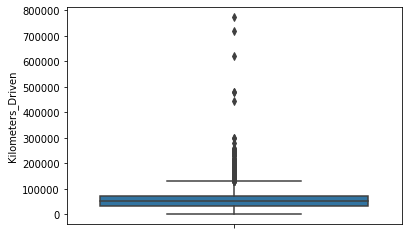

In [19]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Kilometers_Driven')
plt.xticks(fontsize=5)
plt.show()

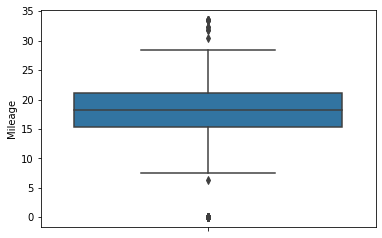

In [20]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Mileage')
plt.xticks(fontsize=5)
plt.show()

Взглянём на автомобили с расходом менее 5 и более 30, т.к. возможно, что это выбросы.

In [21]:
outlier = train_data[train_data['Mileage'] < 5]
print(outlier)
train_data.drop(outlier.index, axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)
outlier = train_data[train_data['Mileage'] > 30]
print(outlier)

      Automatic  Manual  CNG  Diesel  Electric  LPG  Petrol  Ahmedabad   
14          1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0  \
67          1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
189         0.0     1.0  0.0     0.0       0.0  0.0     1.0        1.0   
223         0.0     1.0  0.0     1.0       0.0  0.0     0.0        0.0   
529         1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
688         1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
728         1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
937         1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
971         0.0     1.0  0.0     0.0       0.0  0.0     1.0        0.0   
1034        0.0     1.0  0.0     0.0       0.0  0.0     1.0        0.0   
1231        1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
1279        1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0   
1323        0.0     1.0  0.0     0.0  

Нулевой расход - явно выброс, удаляем.

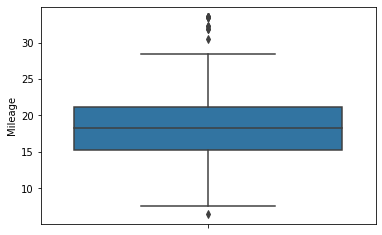

In [22]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Mileage')
plt.xticks(fontsize=5)
plt.show()

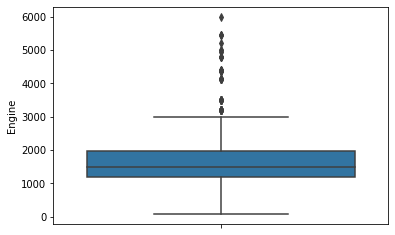

In [23]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Engine')
plt.xticks(fontsize=5)
plt.show()

Взглянём на объём двигателя больше 5000.

In [24]:
outlier = train_data[train_data['Engine'] > 5000]   # No outliers
print(outlier)

      Automatic  Manual  CNG  Diesel  Electric  LPG  Petrol  Ahmedabad   
145         1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0  \
4576        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
4604        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
5387        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
5642        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   

      Bangalore  Chennai  Coimbatore  Delhi  Hyderabad  Jaipur  Kochi   
145         0.0      0.0         0.0    0.0        0.0     0.0    0.0  \
4576        1.0      0.0         0.0    0.0        0.0     0.0    0.0   
4604        0.0      0.0         0.0    0.0        0.0     0.0    0.0   
5387        0.0      0.0         0.0    0.0        1.0     0.0    0.0   
5642        0.0      0.0         0.0    1.0        0.0     0.0    0.0   

      Kolkata  Mumbai  Pune  Audi  BMW  Bentley  Chevrolet  Datsun  Fiat   
145       1.0     0.0   0.0   0.0  0.0  

Выбросов не имеется.

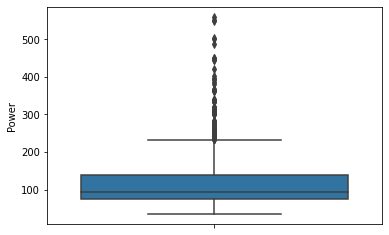

In [25]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Power')
plt.xticks(fontsize=5)
plt.show()

Взглянём на автомобили мощностью более 500.

In [26]:
outlier = train_data[train_data['Power'] > 500]
print(outlier)

      Automatic  Manual  CNG  Diesel  Electric  LPG  Petrol  Ahmedabad   
2043        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0  \
4962        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
5387        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   
5642        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   

      Bangalore  Chennai  Coimbatore  Delhi  Hyderabad  Jaipur  Kochi   
2043        0.0      0.0         0.0    0.0        0.0     0.0    0.0  \
4962        0.0      0.0         1.0    0.0        0.0     0.0    0.0   
5387        0.0      0.0         0.0    0.0        1.0     0.0    0.0   
5642        0.0      0.0         0.0    1.0        0.0     0.0    0.0   

      Kolkata  Mumbai  Pune  Audi  BMW  Bentley  Chevrolet  Datsun  Fiat   
2043      0.0     1.0   0.0   0.0  0.0      0.0        0.0     0.0   0.0  \
4962      0.0     0.0   0.0   0.0  0.0      0.0        0.0     0.0   0.0   
5387      0.0     0.0   0.0   0.0  

Выбросов не имеется.

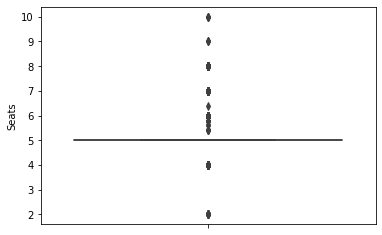

In [27]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Seats')
plt.xticks(fontsize=5)
plt.show()

Нецелочисленные значения из-за того, что они были спрогнозированы через KNNImputer. Округлим их.

In [28]:
train_data['Seats'] = train_data['Seats'].round()

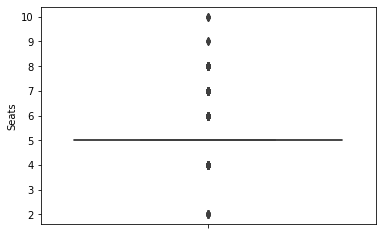

In [29]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Seats')
plt.xticks(fontsize=5)
plt.show()

Выбросов не имеется.

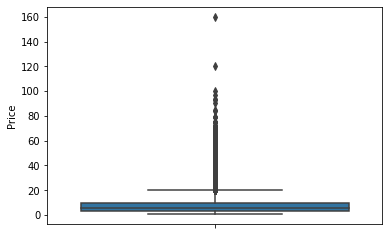

In [30]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Price')
plt.xticks(fontsize=5)
plt.show()

Взглянём на самые дорогостоящие автомобили.

In [31]:
outlier = train_data[train_data['Price'] >= 120]    # Land Rover is more expensive than Lamba ?
print(outlier)
outlier = train_data[train_data['Land Rover'] == 1]
print(outlier)
outlier = train_data[train_data['Price'] == 160]
print(outlier)
train_data.drop(outlier.index, axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)

      Automatic  Manual  CNG  Diesel  Electric  LPG  Petrol  Ahmedabad   
3973        1.0     0.0  0.0     1.0       0.0  0.0     0.0        0.0  \
5642        1.0     0.0  0.0     0.0       0.0  0.0     1.0        0.0   

      Bangalore  Chennai  Coimbatore  Delhi  Hyderabad  Jaipur  Kochi   
3973        0.0      0.0         0.0    0.0        1.0     0.0    0.0  \
5642        0.0      0.0         0.0    1.0        0.0     0.0    0.0   

      Kolkata  Mumbai  Pune  Audi  BMW  Bentley  Chevrolet  Datsun  Fiat   
3973      0.0     0.0   0.0   0.0  0.0      0.0        0.0     0.0   0.0  \
5642      0.0     0.0   0.0   0.0  0.0      0.0        0.0     0.0   0.0   

      Force  Ford  Hindustan  Honda  Hyundai  Isuzu  Jaguar  Jeep   
3973    0.0   0.0        0.0    0.0      0.0    0.0     0.0   0.0  \
5642    0.0   0.0        0.0    0.0      0.0    0.0     0.0   0.0   

      Lamborghini  Land Rover  Mahindra  Maruti  Mercedes-Benz  Mini   
3973          0.0         1.0       0.0     0.0 

Land Rover за 160, что дороже Lamborghini за 120, насторожил меня. Я решил сравнить данную цену с ценами на автомобили марки Land Rover. Сравнение показало, что данная цена с большой долей вероятности является выбросом. Удалим этот объект. В случае с Lamborghini у меня нет достаточных данных для сравнения, поэтому не имеется оснований не доверять данному объекту.

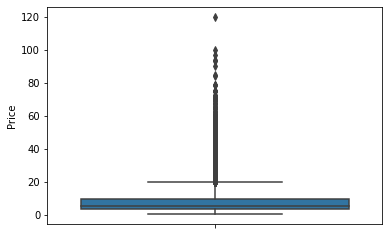

In [32]:
fig = plt.figure()
sns.boxplot(data=train_data, y='Price')
plt.xticks(fontsize=5)
plt.show()

## Исследовательский анализ данных (EDA)

Взглянём на распределение таргета (цены).

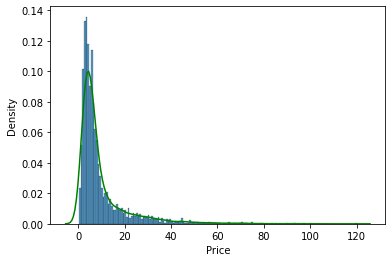

Skewness of price  3.1052527526234397
Kurtosis of price  12.914109483173906


In [33]:
fig = plt.figure()
ax = plt.gca()
sns.histplot(train_data, x='Price', stat='density', ax=ax)
sns.kdeplot(train_data['Price'], color='green', ax=ax)
plt.show()

print('Skewness of price ', train_data['Price'].skew())
print('Kurtosis of price ', train_data['Price'].kurt())

Распределение цены смещено влево, поскольку коэффициент асимметрии больше 0, и имеет острый пик, поскольку коэффициент эксцесса большой, что также свидетельствует о большом числе экстремальных значений в распределении.

Взглянём на корреляционную матрицу.

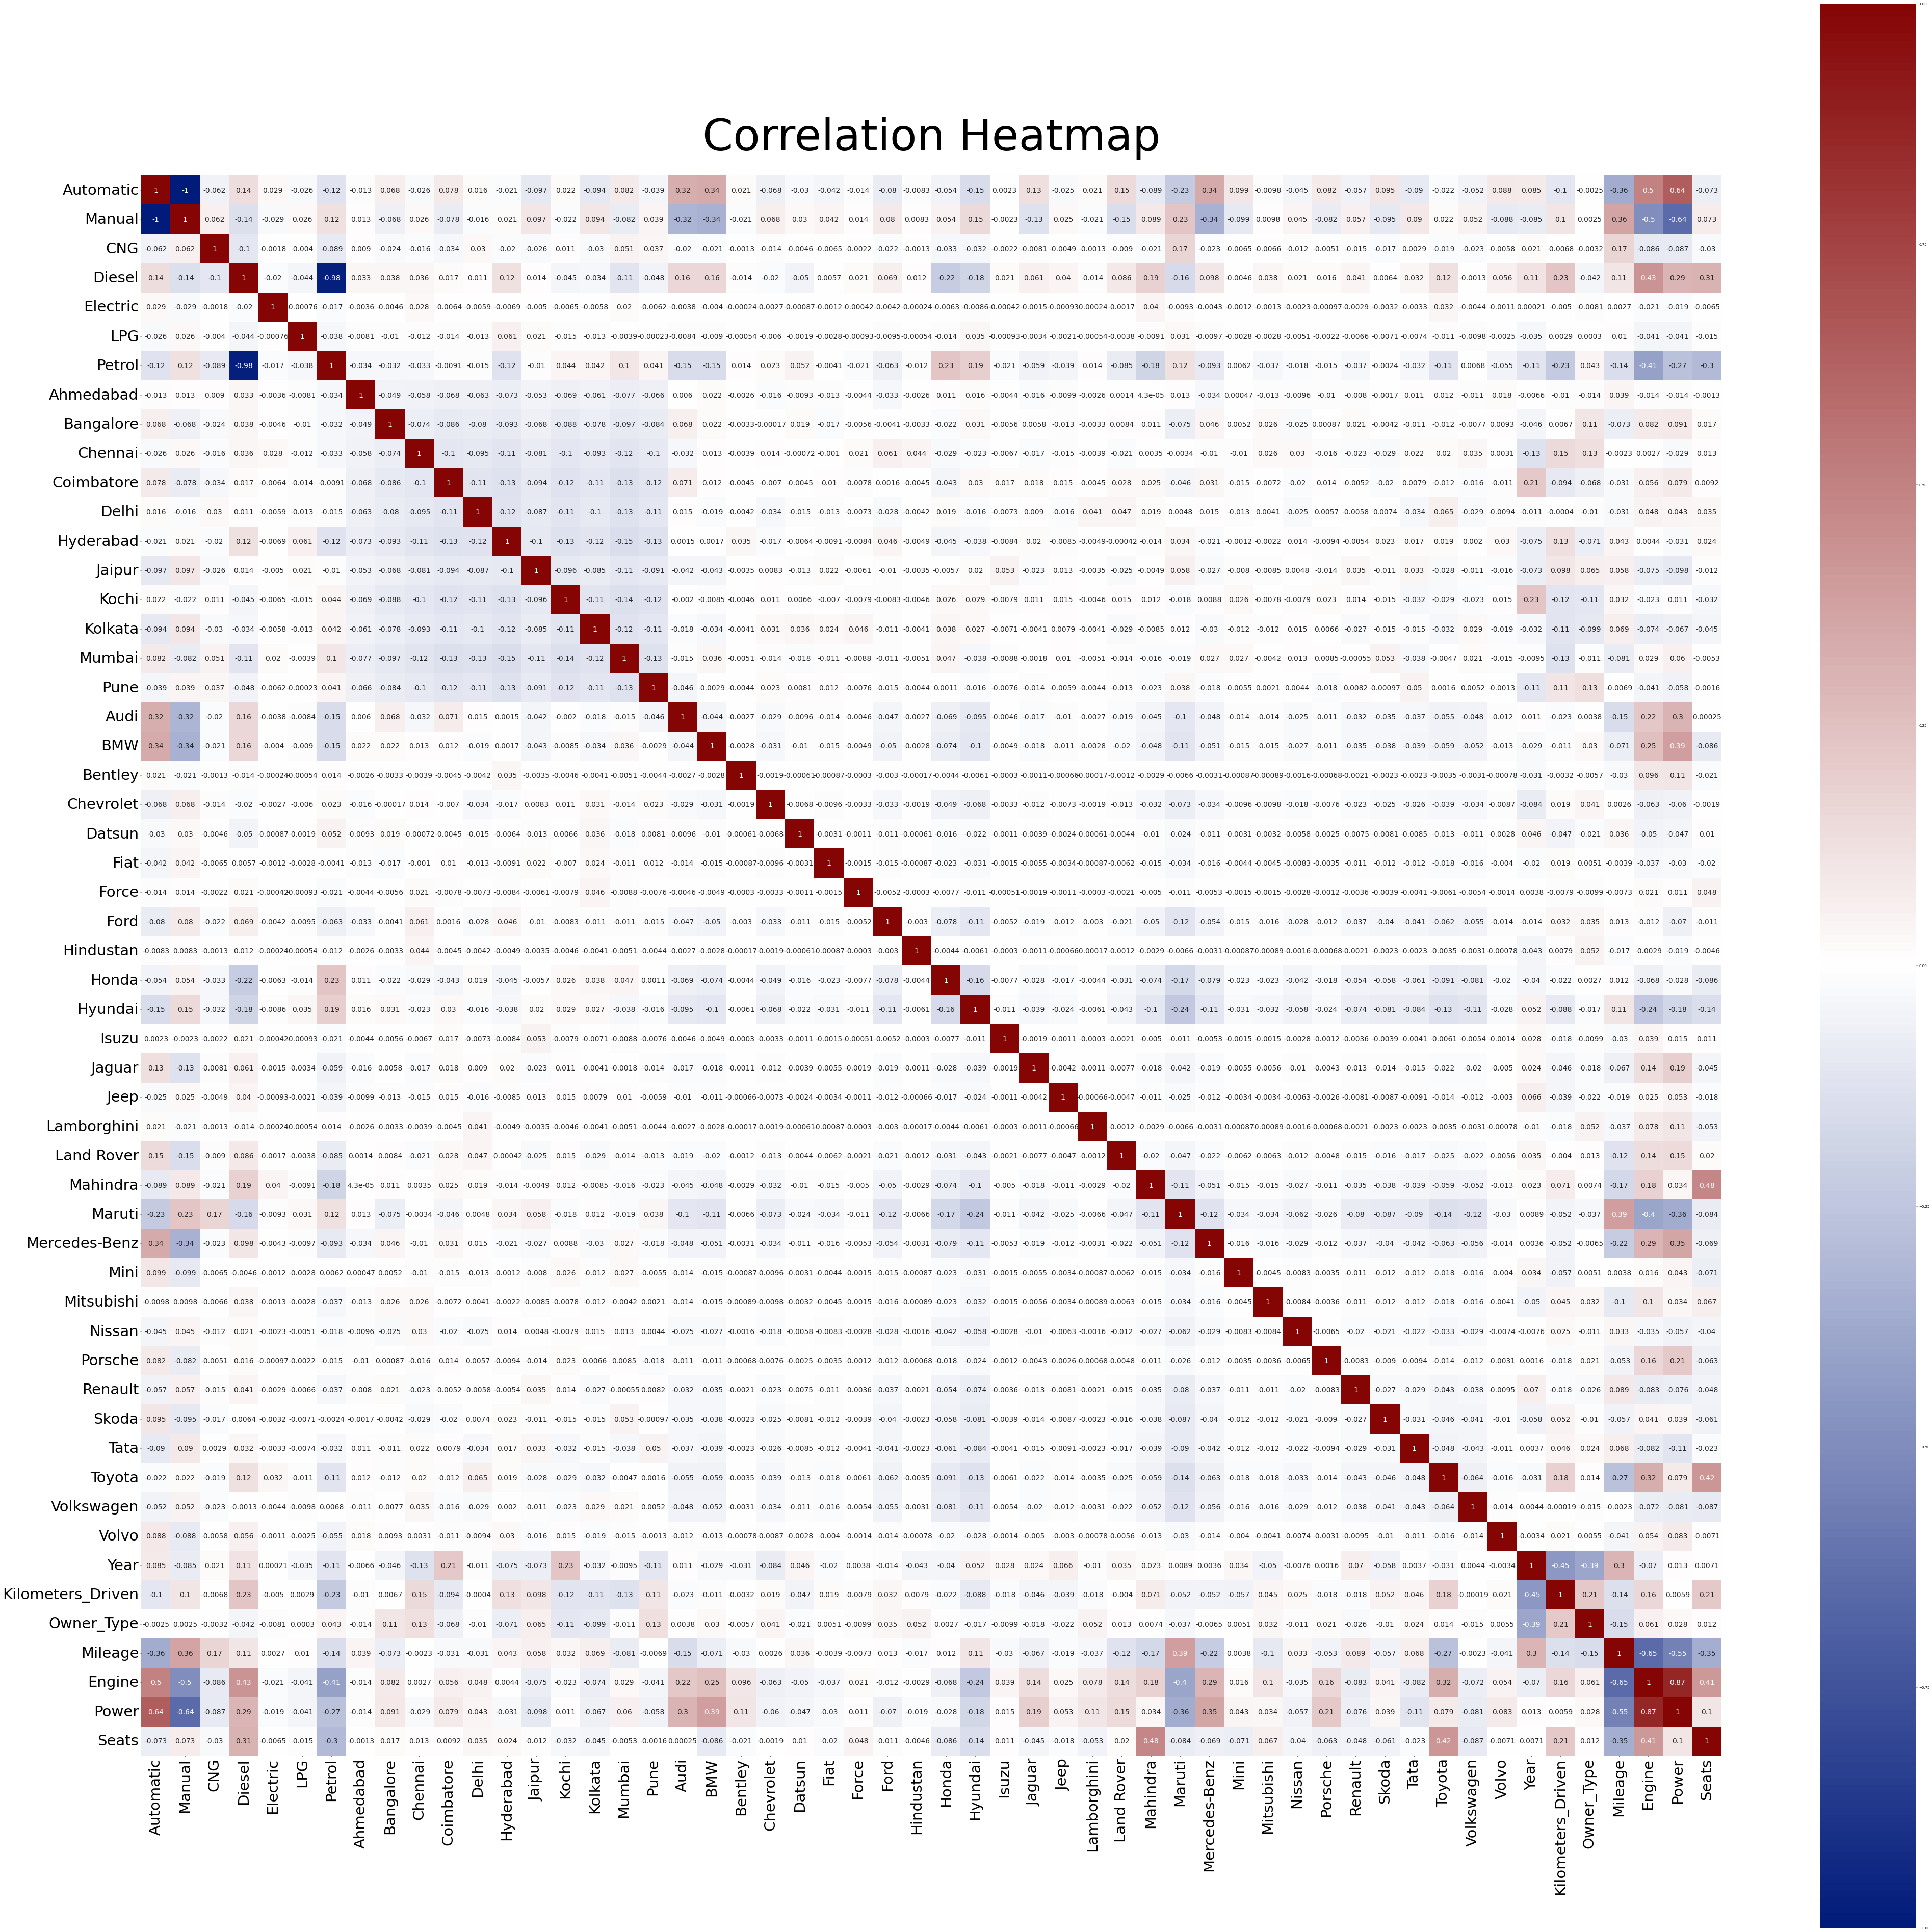

In [34]:
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#011b7a', 'white', '#850505'])
fig, ax = plt.subplots(figsize=(100, 100), dpi=50)
heatmap = sns.heatmap(train_data.drop('Price', axis=1).corr(), cmap=custom_cmap, annot=True, annot_kws={'fontsize':20}, vmin=-1, center=0, vmax=1, square=True)
heatmap.set_title('Correlation Heatmap', fontsize=124, pad=72)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=42)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=42)
plt.show()

Как и ожидалось, имеется корреляция между категориями признаков, полученных через OneHotEncoder. Также имеются корреляции между различными хар-ками автомобиля: мощность коррелирует с расходом, объёмом двигателя, маркой (MB, BMW, Audi, Maruti), трансмиссией и т.п., а год коррелирует с пробегом, числом владельцев, расходом. Число сидений коррелирует с топливом (бензин и дизель), маркой (Mahindra и Toyota), расходом, объёмом двигателя. Объём двигателя коррелирует с трансмиссией, топливом (бензин и дизель), маркой (Maruti и Toyota), расходом, мощностью и числом сидений. Пробег коррелирует с годом и т.д.

Взглянём на корреляцию признаков с таргетом, т.е. с ценой.

Correlation with price
 Price                1.000000
Power                0.780924
Engine               0.661584
Automatic            0.589088
Mercedes-Benz        0.361882
Diesel               0.322491
BMW                  0.309759
Year                 0.300456
Audi                 0.298352
Land Rover           0.259191
Jaguar               0.212422
Porsche              0.189208
Coimbatore           0.173358
Lamborghini          0.131462
Mini                 0.105796
Bangalore            0.090239
Seats                0.059970
Bentley              0.058895
Toyota               0.058691
Kochi                0.054840
Volvo                0.050839
Jeep                 0.042556
Isuzu                0.010724
Mitsubishi           0.009700
Delhi                0.007815
Hyderabad            0.006521
Electric             0.005690
Force               -0.000329
Mumbai              -0.003173
Hindustan           -0.009687
Ahmedabad           -0.020836
LPG                 -0.026377
Datsun          

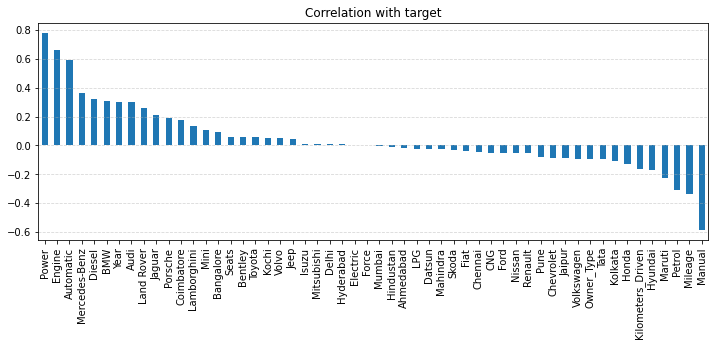

In [35]:
print('Correlation with price\n', train_data.corr().sort_values('Price', ascending=False).Price)
train_data.drop('Price', axis=1).corrwith(train_data['Price']).sort_values(ascending=False).plot(kind='bar', figsize=(12,4), title='Correlation with target')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

Для дальнейшего анализа введём копию данных с исходными категориальными данными, поскольку такой формат более удобный для последующего анализа.

In [36]:
inv_train_data = train_data.copy()
owner_type = pd.DataFrame(ord_enc.inverse_transform(inv_train_data['Owner_Type'].to_numpy()[:, None]), columns=['Owner_Type'])
transmission = pd.DataFrame(onehot_enc_transmission.inverse_transform(inv_train_data.iloc[:, :2]), columns=['Transmission'])
fuel = pd.DataFrame(onehot_enc_fuel.inverse_transform(inv_train_data.iloc[:, 2:7]), columns=['Fuel'])
location = pd.DataFrame(onehot_enc_location.inverse_transform(inv_train_data.iloc[:, 7:18]), columns=['Location'])
maker = pd.DataFrame(onehot_enc_maker.inverse_transform(inv_train_data.iloc[:, 18:47]), columns=['Maker'])
inv_train_data = pd.concat([transmission, fuel, location, maker, inv_train_data.drop(['Automatic', 'Manual', 'CNG', 'Diesel', 'Electric', 'LPG', 'Petrol', 'Ahmedabad', 'Bangalore', 'Chennai', 'Coimbatore', 'Delhi', 'Hyderabad', 'Jaipur', 'Kochi', 'Kolkata', 'Mumbai', 'Pune', 'Audi', 'BMW', 'Bentley', 'Chevrolet', 'Datsun', 'Fiat', 'Force', 'Ford', 'Hindustan', 'Honda', 'Hyundai', 'Isuzu', 'Jaguar', 'Jeep', 'Lamborghini', 'Land Rover', 'Mahindra', 'Maruti', 'Mercedes-Benz', 'Mini', 'Mitsubishi', 'Nissan', 'Porsche', 'Renault', 'Skoda', 'Tata', 'Toyota', 'Volkswagen', 'Volvo', 'Owner_Type'], axis=1), owner_type], axis=1)
inv_train_data['Year'] = inv_train_data['Year'].astype('int').astype('category')
inv_train_data['Seats'] = inv_train_data['Seats'].astype('int').astype('category')

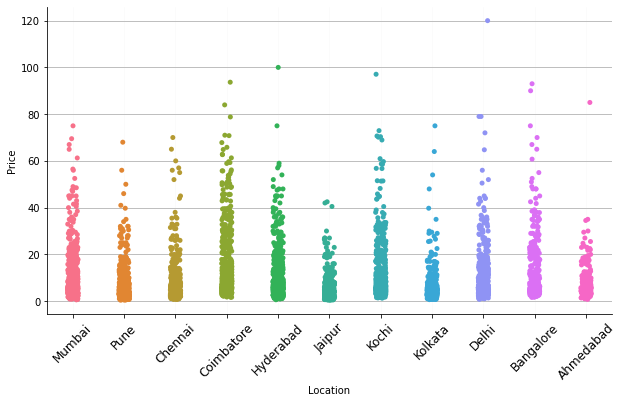

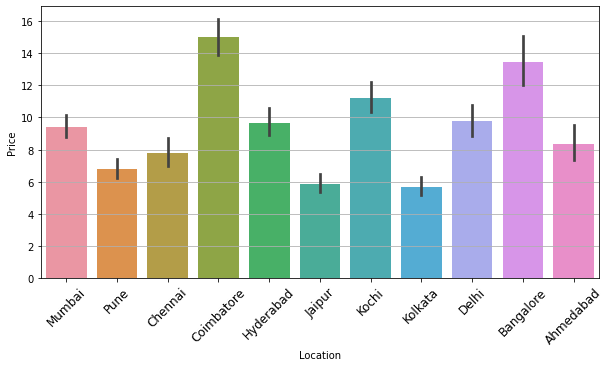

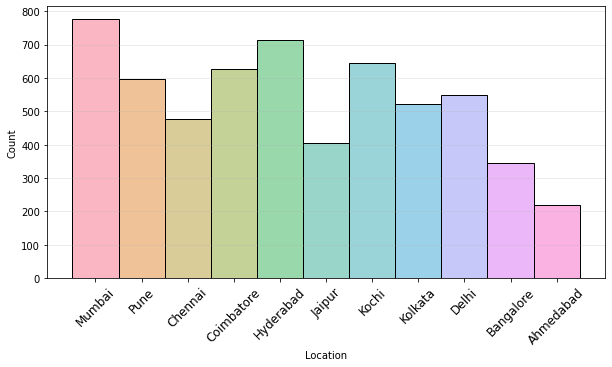

In [37]:
ax = sns.catplot(inv_train_data, x='Location', y='Price', hue='Location')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=45)
ax = sns.barplot(inv_train_data, x='Location', y='Price', hue='Location', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(inv_train_data, x='Location', hue='Location')
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.show()

На первом графике можно увидеть разброс цен по локациям. Например, в Jaipur не продаются дорогие авто, а авто, стоимость которых выше 100, имеются только в Hyderabad и Delhi. На втором графике можно увидеть распределение средних цен по локациям (чёрная линия - доверительный интервал с уровнем доверия 95%). Видно, что в среднем дороже всего стоят автомобили в Coimbatore и Bangalore, дешевле всего - Jaipur и Kolkata. Третий график показывает распределение автомобилей по локациям. Больше всего автомобилей продаётся в Mumbai, меньше всего - в Ahmedabad.

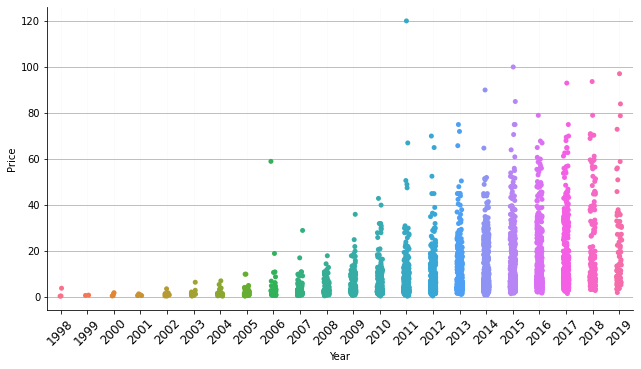

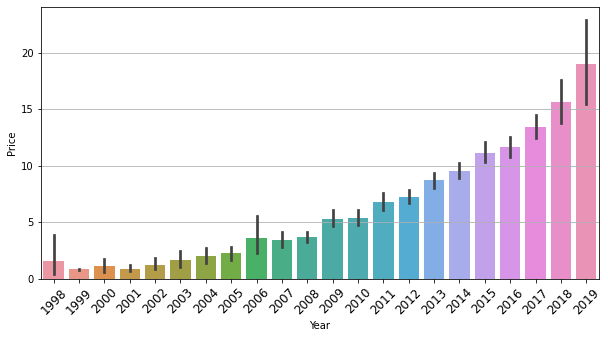

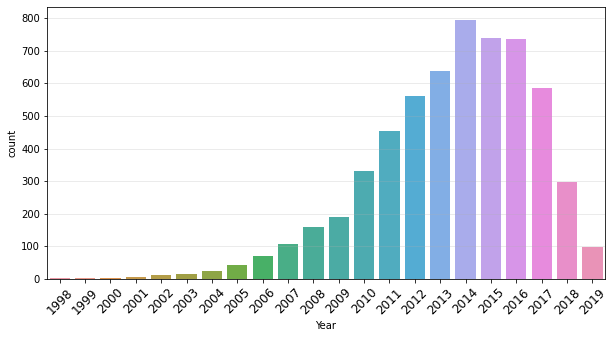

In [38]:
ax = sns.catplot(inv_train_data, x='Year', y='Price', hue='Year')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=45)
ax = sns.barplot(inv_train_data, x='Year', y='Price', hue='Year', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.countplot(inv_train_data, x='Year', hue='Year', dodge=False)
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.show()

На первом графике показано распределение цен в зависимости от года выпуска: видно, что число дорогих авто больше среди более свежих автомобилей. Второй график показывает распределение средних цен в зависимости от года выпуска: средняя цена также возрастает в уменьшением возраста автомобиля. Третий график показывает распределение автомобилей по годам выпуска: больше всего продаётся автомобилей, выпущенных с 2012 года по 2017 год.

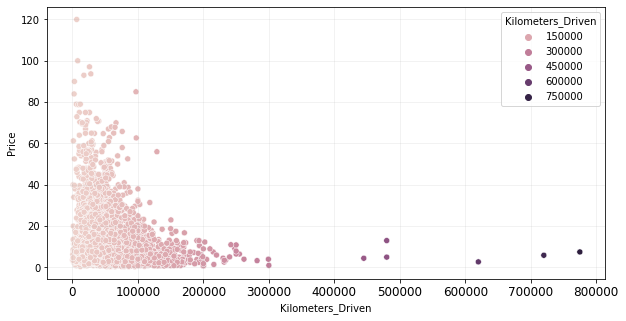

In [39]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(inv_train_data, x='Kilometers_Driven', y='Price', hue='Kilometers_Driven')
plt.grid(axis='both', alpha=0.2, zorder=3)
plt.xticks(fontsize=12)
plt.show()

По представленному выше графику виден разброс цен относительно пробега: наиболее высокие цены у автомобилей с меньшим пробегом. Среди авто с пробегом более 100000 сложно найти автомобиль, который был бы дороже 20.

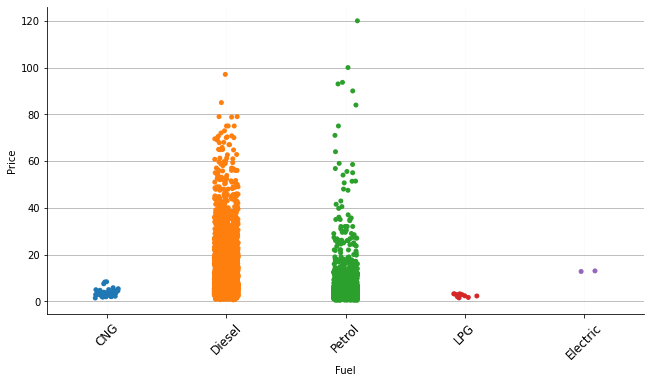

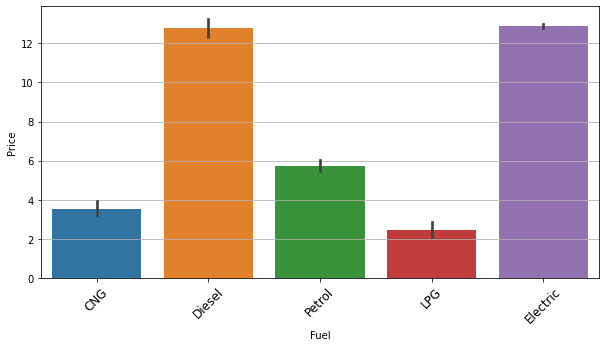

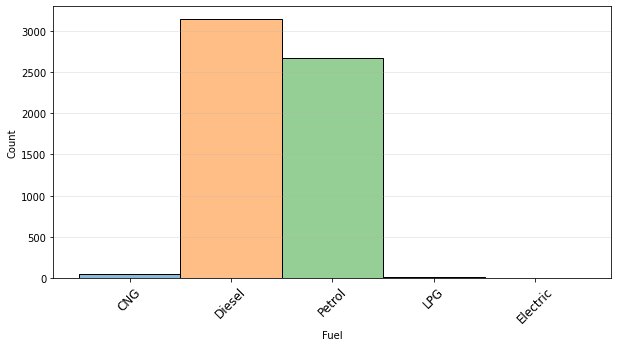

In [40]:
ax = sns.catplot(inv_train_data, x='Fuel', y='Price', hue='Fuel')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=45)
ax = sns.barplot(inv_train_data, x='Fuel', y='Price', hue='Fuel', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(inv_train_data, x='Fuel', hue='Fuel')
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.show()

На первом графике видно, что на авторынке представлены в основном авто с бензиновым и дизельным двигателями, автомобили с иными двигателями в сильном меньшинстве и стоят недорого. Второй график показывает, что в среднем наиболее дорогие автомобили с дизельным и электрическим двигателями. Третий график подтверждает, что на рынке представлены в основном только бензиновый и дизельный тип двигателя.

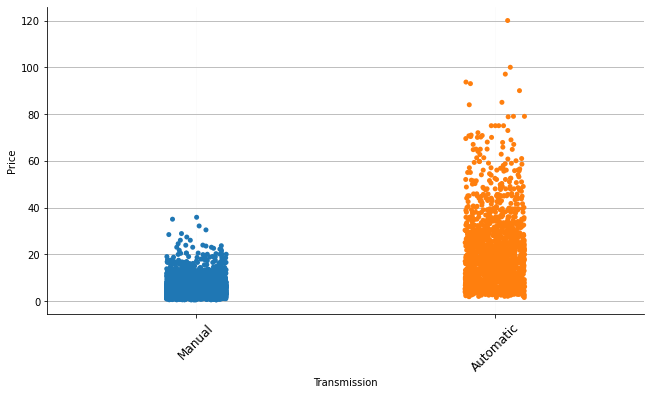

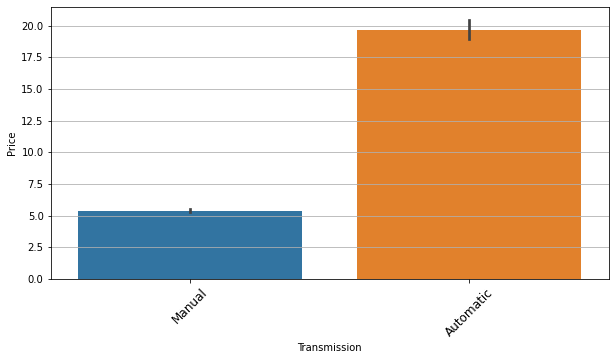

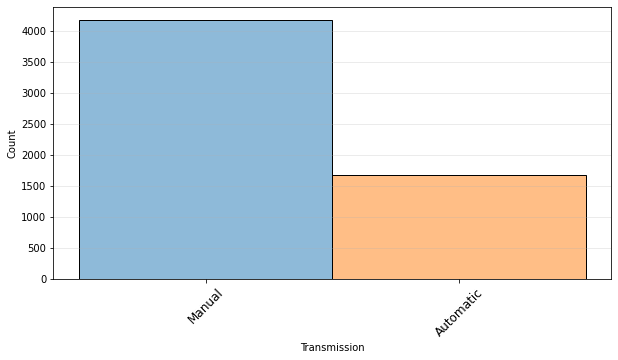

In [41]:
ax = sns.catplot(inv_train_data, x='Transmission', y='Price', hue='Transmission')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=45)
ax = sns.barplot(inv_train_data, x='Transmission', y='Price', hue='Transmission', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(inv_train_data, x='Transmission', hue='Transmission')
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.show()

Первый график показывает, что наиболее дорогие автомобили представлены с автоматической трансмиссией. Второй график также показывает, что автомобили с автоматической трансмиссией в среднем дороже. Третий график показывает, что автомобилей с механической трансмиссией более чем 2 в раза больше представлено на авторынке, чем с автоматической.

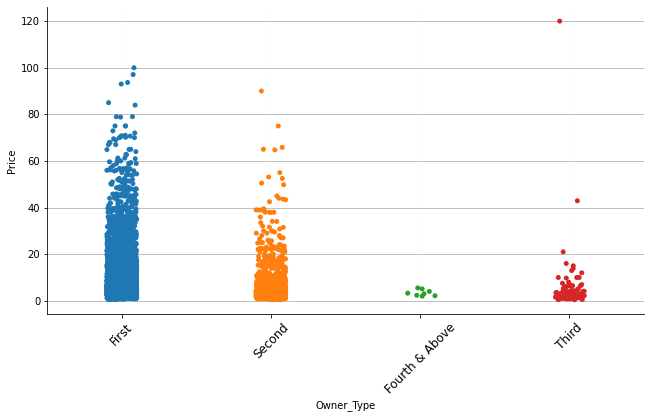

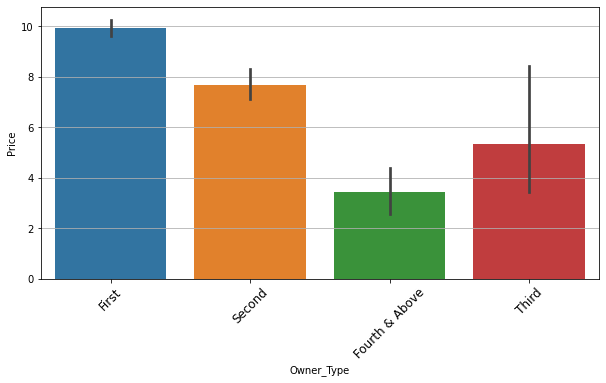

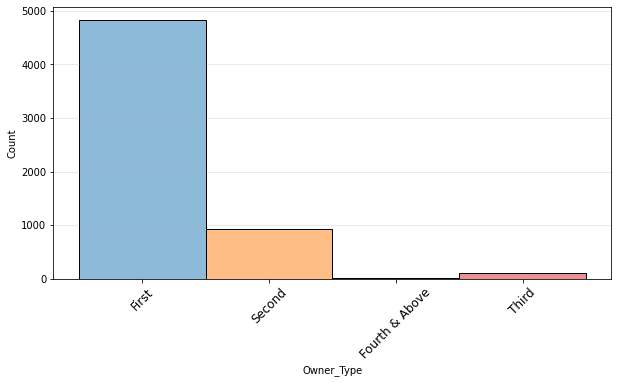

In [42]:
ax = sns.catplot(inv_train_data, x='Owner_Type', y='Price', hue='Owner_Type')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=45)
ax = sns.barplot(inv_train_data, x='Owner_Type', y='Price', hue='Owner_Type', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(inv_train_data, x='Owner_Type', hue='Owner_Type')
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=45)
plt.show()

Первый график показывает, что более-менее дорогие автомобили продаются после первого и второго владельца, хотя самый дорогой представленный автомобиль продаётся после третьего владельца. Авто, у которых было 4+ владельцев, мало, и они наиболее дешёвые.
Второй график подтверждает ожидания: чем больше владельцев, тем ниже средняя цена. Третий график показывает, что почти 80% автомобилей продаётся после первого владельца.

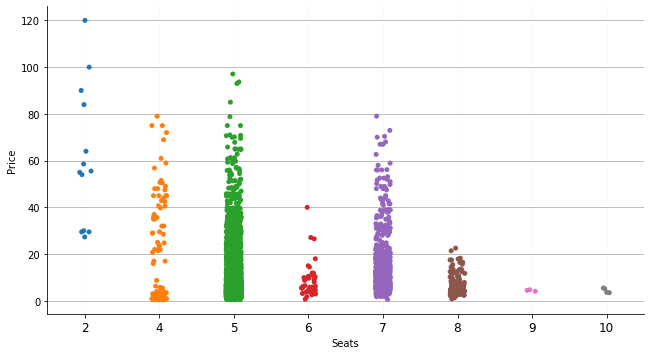

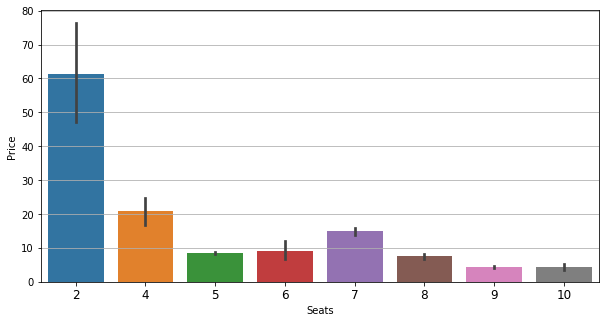

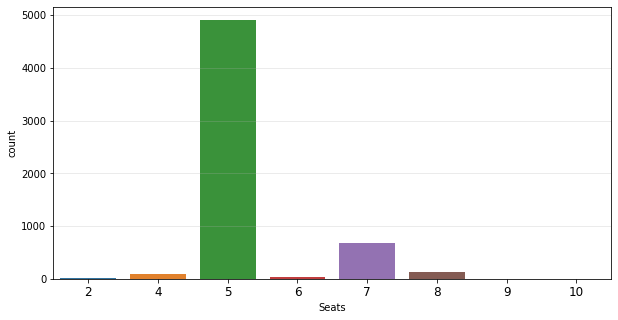

In [43]:
ax = sns.catplot(inv_train_data, x='Seats', y='Price', hue='Seats')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12)
ax = sns.barplot(inv_train_data, x='Seats', y='Price', hue='Seats', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.countplot(inv_train_data, x='Seats', hue='Seats', dodge=False)
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.show()

Из представленных выше графиков можно заметить, что в среднем наиболее дорогие автомобили - автомобили, в который 2 места. Это объяснимо, поскольку 2 места, как правило, в спорткарах и гиперкарах, которые стоят достаточно дорого. Больше всего на авторынке представлено автомобилей, в которых 5 мест.

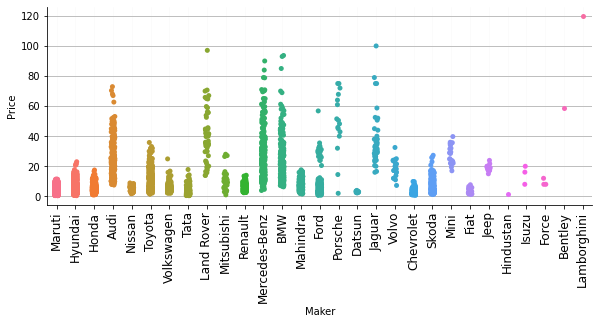

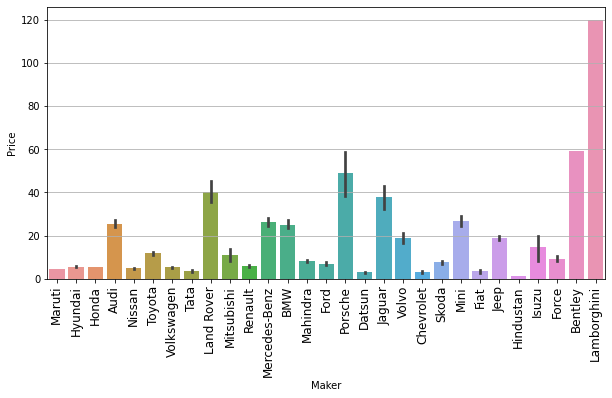

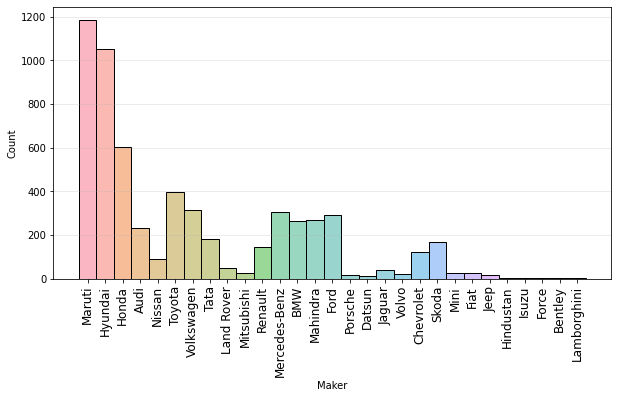

In [44]:
ax = sns.catplot(inv_train_data, x='Maker', y='Price', hue='Maker')
ax.fig.set_size_inches((10, 5))
plt.grid(axis='y')
plt.grid(axis='x', alpha=0.05)
plt.xticks(fontsize=12, rotation=90)
plt.show()

plt.figure(figsize=(10, 5))
plt.grid(axis='y')
plt.xticks(fontsize=12, rotation=90)
ax = sns.barplot(inv_train_data, x='Maker', y='Price', hue='Maker', dodge=False)
ax.legend_.remove()
plt.show()

plt.figure(figsize=(10, 5))
ax = sns.histplot(inv_train_data, x='Maker', hue='Maker')
ax.legend_.remove()
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12, rotation=90)
plt.show()

Самый дорогой автомобиль продаётся под маркой Lamborghini. В среднем, не считая Lamborghini и Bentley, представленные в единственном экземпляре, самые дорогие автомобили - это Porsche, Jaguar, Land Rover, Audi, Mercedes-Benz, BMW, Mini. Больше всего автомобилей на авторынке заявлено под марками Maruti, Hyundai, Honda.

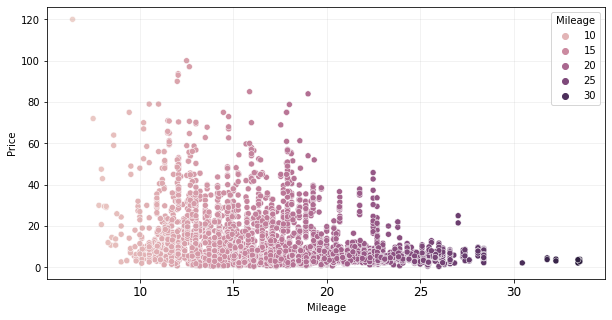

In [45]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(inv_train_data, x='Mileage', y='Price', hue='Mileage')
plt.grid(axis='both', alpha=0.2, zorder=3)
plt.xticks(fontsize=12)
plt.show()

С увеличением расхода верхний предел цены на автомобиль постепенно снижается.

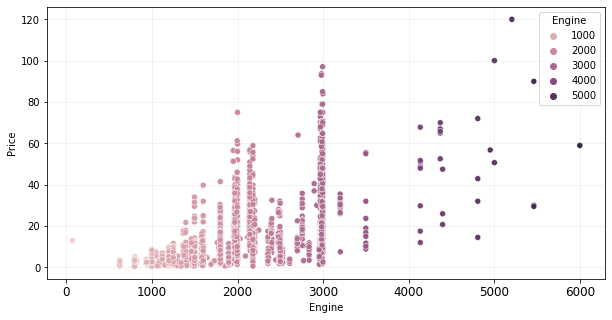

In [46]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(inv_train_data, x='Engine', y='Price', hue='Engine')
plt.grid(axis='both', alpha=0.2, zorder=3)
plt.xticks(fontsize=12)
plt.show()

С увеличением объёма двигателя на авторынке превалируют автомобили с более высокой ценой, заметна прямая корреляция.

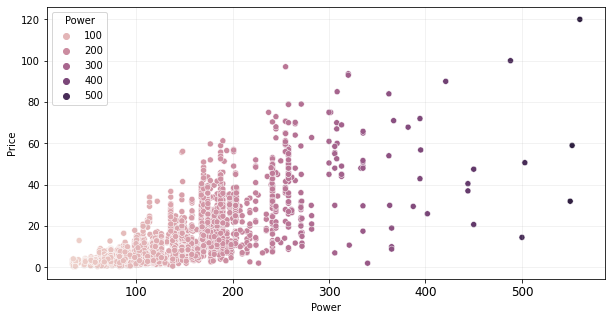

In [47]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(inv_train_data, x='Power', y='Price', hue='Power')
plt.grid(axis='both', alpha=0.2, zorder=3)
plt.xticks(fontsize=12)
plt.show()

С увеличением мощности автомобиля возрастает и его цена, заметна прямая корреляция между мощностью и ценой на авто.

## Анализ влияния признаков на таргет

Взглянём на коэффициент корреляции Пирсона для каждого признака по отношению к таргету.

In [48]:
r_regr = np.abs(r_regression(train_data.drop('Price', axis=1), train_data['Price']))
r_regr = pd.DataFrame(r_regr, columns=["Pearson's correlation"], index=train_data.drop('Price', axis=1).columns).sort_values(by="Pearson's correlation", ascending=False)
print(r_regr)

                   Pearson's correlation
Power                           0.780924
Engine                          0.661584
Manual                          0.589088
Automatic                       0.589088
Mercedes-Benz                   0.361882
Mileage                         0.337843
Diesel                          0.322491
Petrol                          0.310937
BMW                             0.309759
Year                            0.300456
Audi                            0.298352
Land Rover                      0.259191
Maruti                          0.227174
Jaguar                          0.212422
Porsche                         0.189208
Coimbatore                      0.173358
Hyundai                         0.168884
Kilometers_Driven               0.162868
Lamborghini                     0.131462
Honda                           0.125675
Kolkata                         0.108113
Mini                            0.105796
Tata                            0.096253
Owner_Type      

Для каждого категориального признака удалим по одной категории, чтобы уменьшить коррелированность между признаками.

In [49]:
train_data.drop(['Manual', 'Electric', 'Force', 'Mumbai'], axis=1, inplace=True)
test_data.drop(['Manual', 'Electric', 'Force', 'Mumbai'], axis=1, inplace=True)

Оценим дискриминативную способность признаков через тест на основе взаимной информации.

In [50]:
mi_test = mutual_info_regression(train_data.drop('Price', axis=1), train_data['Price'])
mi_test = pd.DataFrame(mi_test, columns=['MI value'], index=train_data.drop('Price', axis=1).columns).sort_values(by='MI value', ascending=False)
print(mi_test)

                   MI value
Power              0.808070
Engine             0.629071
Mileage            0.483880
Year               0.257597
Automatic          0.240249
Diesel             0.127085
Petrol             0.111157
Seats              0.088778
Coimbatore         0.073404
Kilometers_Driven  0.069789
Kochi              0.059294
BMW                0.058300
Mercedes-Benz      0.055962
Audi               0.051628
Maruti             0.049804
Hyundai            0.037193
Toyota             0.035956
Mahindra           0.034715
Land Rover         0.023262
Hyderabad          0.022181
Kolkata            0.021645
Owner_Type         0.021009
Chevrolet          0.019212
Delhi              0.019055
Volkswagen         0.016120
Ford               0.015889
Jaipur             0.015855
Honda              0.014543
Jaguar             0.013539
Pune               0.013311
Porsche            0.012766
Bentley            0.012764
Mini               0.012266
Bangalore          0.011672
Chennai            0

Проверим дискриминативную способность численных признаков на основе F-статистики. Для этого сперва отберём только численные признаки и прогоним их через StandardScaler, чтобы получить одинаковый порядок для каждого признака и нормальное, либо околонормальное распределение.

In [51]:
num_train_data = train_data.iloc[:, 43:]
standard_scaler = StandardScaler()
ss_num_train_data = pd.DataFrame(standard_scaler.fit_transform(num_train_data.drop('Price', axis=1)), columns=num_train_data.drop('Price', axis=1).columns)
num_train_data = pd.concat([ss_num_train_data, num_train_data['Price']], axis=1)
f_regr = f_regression(num_train_data.drop('Price', axis=1), train_data['Price'])
f_regr = pd.DataFrame(f_regr).T.set_index(num_train_data.drop('Price', axis=1).columns).rename(columns={0: 'F_stats', 1: 'p_value'}).sort_values(by='F_stats', ascending=False)
print(f_regr)

                       F_stats        p_value
Power              9172.046094   0.000000e+00
Engine             4567.580659   0.000000e+00
Mileage             756.057711  1.148751e-156
Year                582.292995  9.616963e-123
Kilometers_Driven   159.896393   3.521590e-36
Owner_Type           50.729128   1.187523e-12
Seats                21.179609   4.269949e-06


Уровень статистической значимости зафиксируем 0.05, тогда все признаки являются дискриминативными (нулевая гипотеза отклоняется).

## Построение модели для предсказания цены на автомобиль

Разделим обучающую выборку на трейн и тест.

In [52]:
X = train_data.drop('Price', axis=1)
Y = train_data['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

Чтобы признаки были одного порядка, применим к ним MaxAbsScaler.

In [53]:
maxabsscaler = MaxAbsScaler()
maxabsscaler.fit(X_train)
X_train = maxabsscaler.transform(X_train)
X_test = maxabsscaler.transform(X_test)

Для решения задачи я отобрал следующие регрессионные модели:<br>
1) Ridge (линейная модель с L2 регуляризатором)<br>
2) Lasso (линейная модель с L1 регуляризатором)<br>
3) ElasticNet (линейная модель с комбинацией L1 и L2 регуляризаторов)<br>
4) HuberRegression (робастная линейная модель с функцией потерь Хубера)<br>
5) SVR и NuSVR (регрессионная модель на основе метода опорных векторов)<br>
6) HistGradientBoostingRegressor (гистограммный градиентный бустинг для задачи регрессии)<br>
<br>
Для оценки качества модели я отобрал следующие метрики:<br>
1) MSE<br>
2) MAE<br>
3) MAPE<br>
4) MedAE<br>
5) Max error<br>
6) R2<br>
7) Explained variance<br>
<br>
Код в кавычках ''' используется для подбора оптимальных гиперпараметров через OPTUNA. При необходимости повторного поиска гиперпараметров - кавычки следует удалить.

In [54]:
ridge = RidgeCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100), cv=5)
ridge.fit(X_train, Y_train)
print()
print('Ridge alpha ', ridge.alpha_)
Y_pred = ridge.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))

Y_pred = ridge.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


Ridge alpha  0.001
TRAIN
mean squared error  26.199240786191925
mean absolute error  2.8101664194440654
mean absolute percentage error  0.5352485893181235
median absolute error  1.5007238952053739
max error  51.4614697966108
R2 score  0.7917756945177551
explained variance score  0.7917756945177551
TEST
mean squared error  21.624390959463092
mean absolute error  2.8364805981864616
mean absolute percentage error  0.5466323549500786
median absolute error  1.6271332468425044
max error  30.546535904802795
R2 score  0.780551994239878
explained variance score  0.7825856852897143


In [55]:
lasso = LassoCV(alphas=(0.001, 0.01, 0.1, 1, 10, 100), cv=5)
lasso.fit(X_train, Y_train)
print()
print('Lasso alpha ', lasso.alpha_)
Y_pred = lasso.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = lasso.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


Lasso alpha  0.001
TRAIN
mean squared error  26.961572174895124
mean absolute error  2.8031481744583577
mean absolute percentage error  0.49304035706413674
median absolute error  1.5009694985937359
max error  52.15786093667998
R2 score  0.7857168958962432
explained variance score  0.7857168958962432
TEST
mean squared error  21.94094101188906
mean absolute error  2.7805683172372704
mean absolute percentage error  0.5040561357327263
median absolute error  1.5450917008977059
max error  31.165668812523336
R2 score  0.777339590345666
explained variance score  0.7789619146402594


In [56]:
elasticnet = ElasticNetCV(l1_ratio=(0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1), alphas=(0.001, 0.01, 0.1, 1, 10, 100), cv=5)
elasticnet.fit(X_train, Y_train)
print()
print('Elasticnet alpha ', elasticnet.alpha_)
print('Elasticnet l1_ratio ', elasticnet.l1_ratio_)
Y_pred = elasticnet.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = elasticnet.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


Elasticnet alpha  0.001
Elasticnet l1_ratio  1.0
TRAIN
mean squared error  26.961572174895124
mean absolute error  2.8031481744583577
mean absolute percentage error  0.49304035706413674
median absolute error  1.5009694985937359
max error  52.15786093667998
R2 score  0.7857168958962432
explained variance score  0.7857168958962432
TEST
mean squared error  21.94094101188906
mean absolute error  2.7805683172372704
mean absolute percentage error  0.5040561357327263
median absolute error  1.5450917008977059
max error  31.165668812523336
R2 score  0.777339590345666
explained variance score  0.7789619146402594


In [57]:
'''def objective_huber(trial):
    epsilon = trial.suggest_float('epsilon', 1, 100)
    alpha = trial.suggest_float('alpha', 0, 100)
    max_iter = trial.suggest_int('max_iter', 10, 1000)
    huber = HuberRegressor(epsilon=epsilon, alpha=alpha, max_iter=max_iter)
    huber.fit(X_train, Y_train)
    Y_pred = huber.predict(X_test)
    res = r2_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_huber, n_trials=1000)'''
pass

In [58]:
huber = HuberRegressor(alpha=0.000455734215358404, max_iter=884, epsilon=12.131379689658822)
huber.fit(X_train, Y_train)
print()
print('Huber')
Y_pred = huber.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = huber.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


Huber
TRAIN
mean squared error  26.496686241025643
mean absolute error  2.793725164903681
mean absolute percentage error  0.5102581034490836
median absolute error  1.4918565225493237
max error  51.7976914181927
R2 score  0.7894116804702853
explained variance score  0.7894116968515571
TEST
mean squared error  21.727445341159427
mean absolute error  2.7975550161800022
mean absolute percentage error  0.5213340006154841
median absolute error  1.5812315946366056
max error  30.674411351251592
R2 score  0.7795061808067738
explained variance score  0.7813117017880511


In [59]:
'''def objective_svr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 5)
    coef0 = trial.suggest_float('coef0', -1, 1)
    C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    epsilon = trial.suggest_float('epsilon', 1e-6, 1, log=True)
    print('kernel ', kernel, 'degree ', degree, 'coef0 ', coef0, 'C ', C, 'epsilon ', epsilon)
    model = SVR(kernel=kernel, degree=degree, coef0=coef0, C=C, epsilon=epsilon)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = r2_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_svr, n_trials=1000)'''
pass

In [60]:
svr = SVR(kernel='poly', degree=4, coef0=0.9972691048979285, C=89.5019514918646, epsilon=0.0001369498059435908)
svr.fit(X_train, Y_train)
print()
print('SVR')
Y_pred = svr.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = svr.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


SVR
TRAIN
mean squared error  9.881654331876183
mean absolute error  1.217920196501162
mean absolute percentage error  0.12834604276206393
median absolute error  0.36185356524808765
max error  56.11732748793331
R2 score  0.9214633497564947
explained variance score  0.9218043116032877
TEST
mean squared error  12.292181893221562
mean absolute error  1.9053133442365355
mean absolute percentage error  0.2469044191529623
median absolute error  0.893131244467672
max error  32.13336097794138
R2 score  0.8752568427029989
explained variance score  0.8753103583075865


In [61]:
'''def objective_nusvr(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 5)
    coef0 = trial.suggest_float('coef0', -1, 1)
    C = trial.suggest_float('C', 1e-2, 1e2, log=True)
    nu = trial.suggest_float('nu', 1e-12, 1)
    model = NuSVR(kernel=kernel, degree=degree, coef0=coef0, C=C, nu=nu)
    print(kernel, degree, coef0, C, nu)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = r2_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_nusvr, n_trials=1000)'''
pass

In [62]:
nusvr = NuSVR(kernel='poly', degree=5, coef0=0.12307693943717274, C=41.64638511775881, nu=0.49305680050363)
nusvr.fit(X_train, Y_train)
print()
print('nuSVR')
Y_pred = nusvr.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = nusvr.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


nuSVR
TRAIN
mean squared error  11.836382344585589
mean absolute error  1.5885856707763406
mean absolute percentage error  0.20425468190077264
median absolute error  0.7398493317167267
max error  59.37568718219269
R2 score  0.9059277132021857
explained variance score  0.906190392094825
TEST
mean squared error  14.347399976813247
mean absolute error  2.065746643187998
mean absolute percentage error  0.275769751660402
median absolute error  1.0616440885521614
max error  41.751024889872426
R2 score  0.8544001392382955
explained variance score  0.8544691109402992


In [63]:
'''def objective_sklearnboosting(trial):
    max_depth = trial.suggest_int('max_depth', 4, 16)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 2**max_depth-1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
    l2_regularization = trial.suggest_float('l2_regularization', 1e-6, 1e-6)
    model = HistGradientBoostingRegressor(learning_rate=0.01, max_iter=5000, early_stopping=True, n_iter_no_change=100, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, l2_regularization=l2_regularization)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    res = r2_score(Y_test, Y_pred)
    return res
study = optuna.create_study(direction='maximize')
study.optimize(objective_sklearnboosting, n_trials=1000)'''
pass

In [64]:
sklearn_boosting = HistGradientBoostingRegressor(learning_rate=0.01, max_iter=5000, early_stopping=True, n_iter_no_change=100, max_depth=15, max_leaf_nodes=32227, min_samples_leaf=20, l2_regularization=1e-6)
sklearn_boosting.fit(X_train, Y_train)
print()
print('sklearn boosting')
Y_pred = sklearn_boosting.predict(X_train)
print('TRAIN')
print('mean squared error ', mean_squared_error(Y_train, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_train, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_train, Y_pred))
print('median absolute error ', median_absolute_error(Y_train, Y_pred))
print('max error ', max_error(Y_train, Y_pred))
print('R2 score ', r2_score(Y_train, Y_pred))
print('explained variance score ', explained_variance_score(Y_train, Y_pred))
Y_pred = sklearn_boosting.predict(X_test)
print('TEST')
print('mean squared error ', mean_squared_error(Y_test, Y_pred))
print('mean absolute error ', mean_absolute_error(Y_test, Y_pred))
print('mean absolute percentage error ', mean_absolute_percentage_error(Y_test, Y_pred))
print('median absolute error ', median_absolute_error(Y_test, Y_pred))
print('max error ', max_error(Y_test, Y_pred))
print('R2 score ', r2_score(Y_test, Y_pred))
print('explained variance score ', explained_variance_score(Y_test, Y_pred))


sklearn boosting
TRAIN
mean squared error  4.099575558197051
mean absolute error  0.8461070420208024
mean absolute percentage error  0.1020938557014171
median absolute error  0.3929207546882325
max error  41.35762337495804
R2 score  0.9674177095304431
explained variance score  0.9674217336400459
TEST
mean squared error  6.700997927995832
mean absolute error  1.2812969775112755
mean absolute percentage error  0.15738577492169106
median absolute error  0.5739481335198877
max error  29.2163404560669
R2 score  0.931997130709576
explained variance score  0.9320535221960882


По приведённым выше результатам наилучшей моделью оказался градиентный бустинг с R2 93%, explained variance 93%, MSE = 6.7, MAE = 1.28.

Используя наилучшую модель, предскажем тестовый набор данных, имеющийся у нас изначально.

In [65]:
maxabsscaler.fit(X)
test_data = maxabsscaler.transform(test_data)
result = sklearn_boosting.predict(test_data)
print(result)

[ 2.57004714  3.11432888 17.32573815 ...  2.89392907  5.15595081
 17.65508355]
